In [1]:
import pandas as pd
import numpy as np
import tqdm
import sys
import os

In [2]:
files = os.listdir('./data/5m/unzipped')

column_names = ['open-time','open','high','low','close-price',
                'volume','close-time','quote-asset-volume','number-of-trades','taker-buy-base-asset-volume',
                'Taker-buy-quote-asset-volume','ignore']
df_list = list()
for file in files:
    df = pd.read_csv(f'./data/5m/unzipped/{file}',names=column_names)
    df_list.append(df)
df = pd.concat(df_list,axis=0).sort_values(by=['close-time']).reset_index(drop=True)
df['is-kline-close'] = True
df.head()

,open-time,open,high,low,close-price,volume,close-time,quote-asset-volume,number-of-trades,taker-buy-base-asset-volume,Taker-buy-quote-asset-volume,ignore,is-kline-close
0,1614556800000,1020.39,1026.96,1017.57,1018.31,83.28719,1614557099999,85170.655325,347,34.02681,34818.031714,0,True
1,1614557100000,1017.93,1020.11,1014.28,1019.98,88.70572,1614557399999,90190.033997,271,71.18097,72369.624775,0,True
2,1614557400000,1019.78,1022.13,1016.61,1022.13,89.66924,1614557699999,91333.413579,365,52.91799,53908.221023,0,True
3,1614557700000,1022.92,1039.02,1021.96,1037.39,207.35606,1614557999999,213826.940568,278,101.22721,104511.806466,0,True
4,1614558000000,1038.53,1040.04,1032.72,1036.42,95.59525,1614558299999,99074.279068,370,34.25878,35560.577470,0,True


In [3]:
df.shape

(39640, 13)

In [4]:
df = df.sort_values(by=['close-time']).drop_duplicates(subset=['close-time'])

In [5]:
df.shape

(39640, 13)

In [6]:
df.to_csv('./data/5m/full_data_5m.csv')

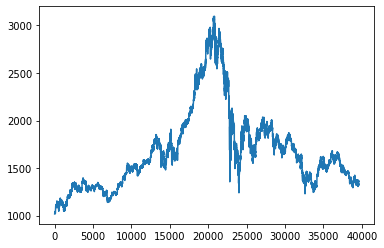

In [7]:
df['close-price'].plot()

In [8]:
df['close-price-pct_change_30'] = df['close-price'].pct_change(30)
df['close-price-pct_change_1'] = df['close-price'].pct_change(1)
df.shape

def rsi(series):
    diff = series.diff()
    ups = np.where(diff>0,diff,0).mean()
    downs = -np.where(diff<=0,diff,0).mean()
    
    #print(ups,downs)
    rs = ups/downs
    rsi = 100-100/(1+rs)
    return rsi

df['rsi'] = df['close-price'].rolling(100).apply(lambda x: rsi(x))

In [9]:
df.shape

(39640, 16)

In [10]:
df[-100:].shape

(100, 16)

In [11]:
df['volume_pct_change_1'] = df['volume'].diff()

In [12]:
df.head()

,open-time,open,high,low,close-price,volume,close-time,quote-asset-volume,number-of-trades,taker-buy-base-asset-volume,Taker-buy-quote-asset-volume,ignore,is-kline-close,close-price-pct_change_30,close-price-pct_change_1,rsi,volume_pct_change_1
0,1614556800000,1020.39,1026.96,1017.57,1018.31,83.28719,1614557099999,85170.655325,347,34.02681,34818.031714,0,True,NaN,NaN,NaN,NaN
1,1614557100000,1017.93,1020.11,1014.28,1019.98,88.70572,1614557399999,90190.033997,271,71.18097,72369.624775,0,True,NaN,0.001640,NaN,5.41853
2,1614557400000,1019.78,1022.13,1016.61,1022.13,89.66924,1614557699999,91333.413579,365,52.91799,53908.221023,0,True,NaN,0.002108,NaN,0.96352
3,1614557700000,1022.92,1039.02,1021.96,1037.39,207.35606,1614557999999,213826.940568,278,101.22721,104511.806466,0,True,NaN,0.014930,NaN,117.68682
4,1614558000000,1038.53,1040.04,1032.72,1036.42,95.59525,1614558299999,99074.279068,370,34.25878,35560.577470,0,True,NaN,-0.000935,NaN,-111.76081


# Context

0.002% is the threshold for profit. Aim for a 1 percent gain in 1 day?

In [13]:
df.shape

(39640, 17)

In [14]:
288/4

72.0

In [ ]:
X_list = list()
y_list = list()

lookback = 100
forward = 50
n = df.shape[0]
for i in tqdm.tqdm(range(n)):
    
    if lookback<i<(n-(lookback+forward+1)):
        x = df.loc[i:i+lookback,'close-price-pct_change_30'].reset_index(drop=True).to_frame(name=f'iter-{i}').T
        x_2 = df.loc[i:i+lookback,'volume_pct_change_1'].reset_index(drop=True).to_frame(name=f'iter-{i}').T
        x_2.columns = [f'volume-{x}' for x in x_2.columns]
        
        #x_3 = pd.DataFrame(df.loc[i,'rsi'],index=[f'iter-{i}'],columns=['rsi'])
        
        x_4 =  pd.concat([x,x_2],axis=1)
        X_list.append(x_4)
        
        outcome = df.loc[(i+lookback+1):(i+lookback+forward),'close-price-pct_change_1'].sum()
        outcome = True if outcome>0.04 else False
        y_list.append(outcome)

        
print('Creating the covariate matrix')
X = pd.concat(X_list,axis=0).values

print('creating target outcome')
y = np.array(y_list)

 94%|█████████▍| 37272/39640 [01:19<00:04, 539.68it/s]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape

In [ ]:
X_train,X_test,y_train,y_test = X[:15000],X[15000:],y[:15000],y[15000:]

In [ ]:
X.shape

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
import joblib

def save_object(obj,filename):
    with open(filename,'wb') as file:
        joblib.dump(obj,file)


save_object(X_train,'X_train.bz2')
save_object(X_test,'X_test.bz2')
save_object(y_train,'y_train.bz2')
save_object(y_test,'y_test.bz2')

In [ ]:
X_train = joblib.load('X_train.bz2')
X_test = joblib.load('X_test.bz2')

y_train = joblib.load('y_train.bz2')
y_test = joblib.load('y_test.bz2')

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

clf = RandomForestClassifier(n_estimators=100,max_depth=25,min_samples_leaf=1300)
#clf = MLPClassifier((100,10),verbose=True,validation_fraction=0.3,tol=0.1,n_iter_no_change=2)
#clf = LogisticRegression()
clf.fit(X_train,y_train)

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

In [ ]:
pd.DataFrame(clf.predict_proba(X_test)).plot.hist(bins=100,histtype='step')

In [ ]:
from sklearn.metrics import plot_roc_curve
from matplotlib import pyplot as plt

fig,axes = plt.subplots(1,1,figsize=[10,7])
plot_roc_curve(clf, X_test, y_test,ax=axes,ls='--')
plot_roc_curve(clf, X_train, y_train,ax=axes)
axes.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
plt.show()

In [ ]:
2*0.78-1

In [ ]:
fig,axes = plt.subplots(1,1,figsize=[15,10])

axes.plot(df[15000:16000]['close-price'].values,label='price')
axes2 = axes.twinx()
axes2.plot(clf.predict_proba(X_test[:1000])[:,1],c='r',label='prob 5% rally in the next 30 days')

# Fitting a simple neural net

In [147]:
#from keras.layers import Dense
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
#from tensorflow import keras
#from keras.layers import Dense

df = pd.read_csv('./data/5m/full_data_5m.csv',index_col=0)
df['close-datetime'] = pd.to_datetime(df['close-time'],unit='ms')
df = df.set_index('close-datetime')
df['close-price-pct'] = df['close-price'].pct_change()
df['volume-pct'] = df['volume'].pct_change()
df['rolling_growth_30'] = df['close-price-pct'].rolling(5,min_periods=5).sum()

# Creating the target variable
df['close_price_pct_reverse'] = df['close-price-pct'].to_numpy()[::-1]
df['close_price_pct_rolling_sum_30'] = df['close_price_pct_reverse'].rolling(30,min_periods=30).sum().to_numpy()[::-1]
df.head()

,open-time,open,high,low,close-price,volume,close-time,quote-asset-volume,number-of-trades,taker-buy-base-asset-volume,Taker-buy-quote-asset-volume,ignore,is-kline-close,close-price-pct,volume-pct,rolling_growth_30,close_price_pct_reverse,close_price_pct_rolling_sum_30
close-datetime,,,,,,,,,,,,,,,,,,
2021-03-01 00:04:59.999,1614556800000,1020.39,1026.96,1017.57,1018.31,83.28719,1614557099999,85170.655325,347,34.02681,34818.031714,0,True,NaN,NaN,NaN,-0.000776,NaN
2021-03-01 00:09:59.999,1614557100000,1017.93,1020.11,1014.28,1019.98,88.70572,1614557399999,90190.033997,271,71.18097,72369.624775,0,True,0.001640,0.065058,NaN,0.001909,0.023937
2021-03-01 00:14:59.999,1614557400000,1019.78,1022.13,1016.61,1022.13,89.66924,1614557699999,91333.413579,365,52.91799,53908.221023,0,True,0.002108,0.010862,NaN,0.001201,0.020571
2021-03-01 00:19:59.999,1614557700000,1022.92,1039.02,1021.96,1037.39,207.35606,1614557999999,213826.940568,278,101.22721,104511.806466,0,True,0.014930,1.312455,NaN,0.000824,0.017790
2021-03-01 00:24:59.999,1614558000000,1038.53,1040.04,1032.72,1036.42,95.59525,1614558299999,99074.279068,370,34.25878,35560.577470,0,True,-0.000935,-0.538980,NaN,-0.000688,0.000698


In [153]:
lookback = 200
def create_dataset(dataset, look_back=10):
    dataX, dataY = list(), list()
    for i in range(len(dataset)-look_back-1):
        
        cols = df.columns.tolist()
        covars = ['close-price-pct','volume-pct','rolling_growth_30']
        covars_indices = [cols.index(x) for x in covars]
        
        vars_indices = [cols.index('close_price_pct_rolling_sum_30')]
        
        i_p_look_back = i+look_back
        
        a = dataset.iloc[i:i_p_look_back,covars_indices]
        dataX.append(a)
        dataY.append(dataset.iloc[(i_p_look_back+1),vars_indices])
    return np.array(dataX), np.array(dataY)

X,y = create_dataset(df.dropna(axis=0),lookback)

X_train,X_test = X[:20000],X[20000:]
y_train,y_test = y[:20000],y[20000:]

def repack(x):
    n,m,k = x.shape
    return x.reshape(n,1,m*k).astype('float32'),m*k

X_train,_ = repack(X_train)
X_test,dim = repack(X_test)
y_train = y_train.astype('float32')

In [154]:
model = keras.Sequential()
model.add(Dense(100,input_dim=dim))
model.add(Dense(20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=25, verbose=1)

Epoch 1/20
800/800 [==============================] - 2s 2ms/step - loss: 116.6215
Epoch 2/20
800/800 [==============================] - 2s 2ms/step - loss: 6.1969
Epoch 3/20
800/800 [==============================] - 1s 2ms/step - loss: 0.9424
Epoch 4/20
800/800 [==============================] - 2s 2ms/step - loss: 4.2833
Epoch 5/20
800/800 [==============================] - 2s 2ms/step - loss: 23.1243
Epoch 6/20
800/800 [==============================] - 2s 2ms/step - loss: 9.0649
Epoch 7/20
800/800 [==============================] - 2s 2ms/step - loss: 4.0465
Epoch 8/20
800/800 [==============================] - 2s 2ms/step - loss: 4.4086
Epoch 9/20
800/800 [==============================] - 2s 2ms/step - loss: 5.7056
Epoch 10/20
800/800 [==============================] - 2s 2ms/step - loss: 3.1841
Epoch 11/20
800/800 [==============================] - 2s 2ms/step - loss: 2.7273
Epoch 12/20
800/800 [==============================] - 2s 2ms/step - loss: 1.9799
Epoch 13/20
800/800 [=

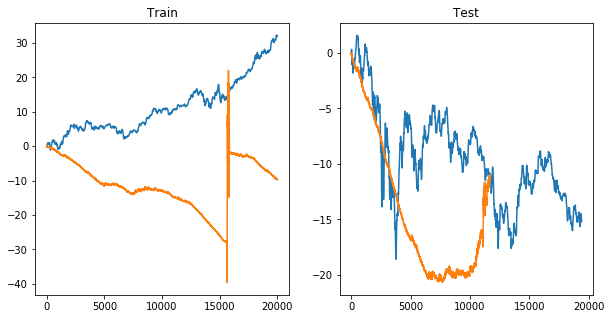

In [155]:
from matplotlib import pyplot as plt

fig,axes = plt.subplots(1,2,figsize=[10,5])

axes[0].plot(np.cumsum(y_train))
axes[0].plot(np.cumsum(model.predict(X_train)))
axes[0].set_title('Train')

axes[1].plot(np.cumsum(y_test))
axes[1].plot(np.cumsum(model.predict(X_test)))
axes[1].set_title('Test')

plt.show()

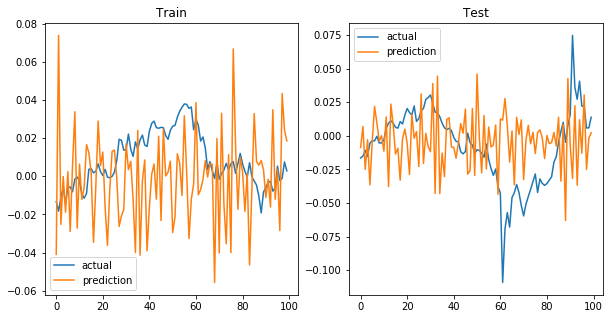

In [157]:
from matplotlib import pyplot as plt

fig,axes = plt.subplots(1,2,figsize=[10,5])

axes[0].plot(y_train[:100],label='actual')
axes[0].plot(model.predict(X_train[:100]).ravel(),label='prediction')
axes[0].set_title('Train')
axes[0].legend()

axes[1].plot(y_test[:100],label='actual')
axes[1].plot(model.predict(X_test[:100]).ravel(),label='prediction')
axes[1].set_title('Test')
axes[1].legend()

plt.show()

# Fitting an LTSM model

In [137]:
#from keras.layers import Dense
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense
#from tensorflow import keras
#from keras.layers import Dense

df = pd.read_csv('./data/5m/full_data_5m.csv',index_col=0)
df['close-datetime'] = pd.to_datetime(df['close-time'],unit='ms')
df = df.set_index('close-datetime')
df['close-price-pct'] = df['close-price'].pct_change()
df['volume-pct'] = df['volume'].pct_change()
df['rolling_growth_30'] = df['close-price-pct'].rolling(5,min_periods=5).sum()

# Creating the target variable
df['close_price_pct_reverse'] = df['close-price-pct'].to_numpy()[::-1]
df['close_price_pct_rolling_sum_30'] = df['close_price_pct_reverse'].rolling(30,min_periods=30).sum().to_numpy()[::-1]

In [160]:
lookback = 100
def create_dataset(dataset, look_back=10):
    dataX, dataY = list(), list()
    for i in range(len(dataset)-look_back-1):
        
        cols = df.columns.tolist()
        covars = ['close-price-pct','volume-pct']
        covars_indices = [cols.index(x) for x in covars]
        
        vars_indices = [cols.index('close_price_pct_rolling_sum_30')]
        
        i_p_look_back = i+look_back
        
        a = dataset.iloc[i:i_p_look_back,covars_indices]
        dataX.append(a)
        dataY.append(dataset.iloc[(i_p_look_back+1),vars_indices])
    return np.array(dataX), np.array(dataY)

X,y = create_dataset(df.dropna(axis=0),lookback)

In [161]:
X_it,X_oot = X[:30000],X[30000:]
y_it,y_oot = y[:30000],y[30000:]

In [162]:
X_it.shape

(30000, 100, 2)

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_it, y_it, test_size=0.33, random_state=42)

def repack(x):
    n,m,k = x.shape
    return x.reshape(n,1,m*k).astype('float32'),m*k

X_train,_ = repack(X_train)
X_test,dim = repack(X_test)
y_train = y_train.astype('float32')

X_it,_ = repack(X_it)
X_oot,_ = repack(X_oot)

In [164]:
X_it.shape

(30000, 1, 200)

In [165]:
X_train.shape

(20100, 1, 200)

In [166]:
X_oot.shape

(9505, 1, 200)

In [167]:
model = keras.Sequential()
#model.add(Dense(100,input_dim=dim))
model.add(LSTM(30, input_shape=(1, dim)))
model.add(Dense(5))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=500, verbose=1)

Epoch 1/100
41/41 [==============================] - 2s 5ms/step - loss: 0.0266
Epoch 2/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0034
Epoch 4/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 5/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 7/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0012
Epoch 8/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 9/100
41/41 [==============================] - 0s 5ms/step - loss: 9.2497e-04
Epoch 10/100
41/41 [==============================] - 0s 5ms/step - loss: 8.6680e-04
Epoch 11/100
41/41 [==============================] - 0s 5ms/step - loss: 8.0876e-04
Epoch 12/100
41/41 [==============================] - 0s 5ms/step - loss: 7.5190e-04
Epoch 13/100
41/41 [=

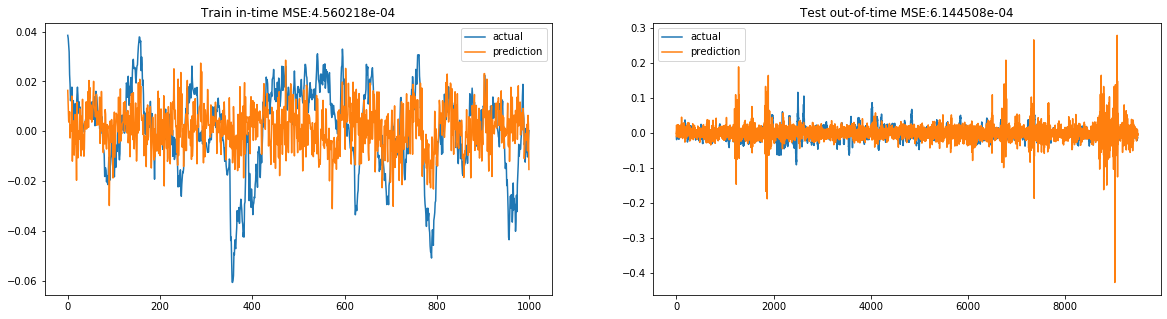

In [168]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

fig,axes = plt.subplots(1,2,figsize=[20,5])

axes[0].plot(y_it[:1000],label='actual')
axes[0].plot(model.predict(X_it[:1000]).ravel(),label='prediction')
mse_train = mean_squared_error(y_it,model.predict(X_it))
axes[0].set_title(f'Train in-time MSE:{mse_train:-4e}')
axes[0].legend()

axes[1].plot(y_oot,label='actual')
axes[1].plot(model.predict(X_oot).ravel(),label='prediction')
mse_test = mean_squared_error(y_oot,model.predict(X_oot))
axes[1].set_title(f'Test out-of-time MSE:{mse_test:-4e}')
axes[1].legend()

plt.show()

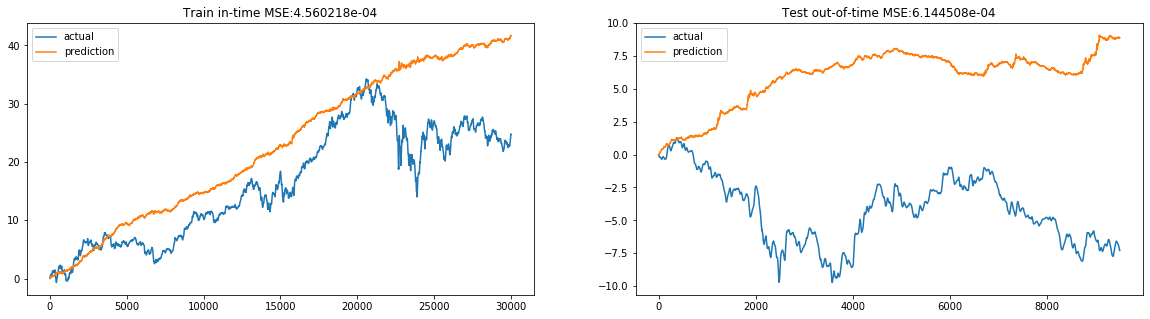

In [169]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

fig,axes = plt.subplots(1,2,figsize=[20,5])

axes[0].plot(np.cumsum(y_it),label='actual')
axes[0].plot(np.cumsum(model.predict(X_it).ravel()),label='prediction')
mse_train = mean_squared_error(y_it,model.predict(X_it))
axes[0].set_title(f'Train in-time MSE:{mse_train:-4e}')
axes[0].legend()

axes[1].plot(np.cumsum(y_oot),label='actual')
axes[1].plot(np.cumsum(model.predict(X_oot).ravel()),label='prediction')
mse_test = mean_squared_error(y_oot,model.predict(X_oot))
axes[1].set_title(f'Test out-of-time MSE:{mse_test:-4e}')
axes[1].legend()

plt.show()

# Fitting LTSM to absolute values not pct_change

In [91]:
#from keras.layers import Dense
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
#from tensorflow import keras
#from keras.layers import Dense

df = pd.read_csv('./data/5m/full_data_5m.csv',index_col=0)
df['close-datetime'] = pd.to_datetime(df['close-time'],unit='ms')
df = df.set_index('close-datetime')
df['close-price-pct'] = df['close-price'].pct_change()
df['close-price-pct-30'] = df['close-price'].pct_change(30)
df['close-price-pct-5'] = df['close-price'].pct_change(5)
df['volume-pct'] = df['volume'].diff()
df['rolling_growth_30'] = df['close-price-pct'].rolling(30,min_periods=30).sum()

# Creating the target variable
df['close_price_pct_reverse'] = df['close-price-pct'].to_numpy()[::-1]
df['close_price_pct_rolling_sum_30'] = df['close_price_pct_reverse'].rolling(30,min_periods=30).sum().to_numpy()[::-1]

In [92]:
df.head()

,open-time,open,high,low,close-price,volume,close-time,quote-asset-volume,number-of-trades,taker-buy-base-asset-volume,Taker-buy-quote-asset-volume,ignore,is-kline-close,close-price-pct,close-price-pct-30,close-price-pct-5,volume-pct,rolling_growth_30,close_price_pct_reverse,close_price_pct_rolling_sum_30
close-datetime,,,,,,,,,,,,,,,,,,,,
2021-03-01 00:04:59.999,1614556800000,1020.39,1026.96,1017.57,1018.31,83.28719,1614557099999,85170.655325,347,34.02681,34818.031714,0,True,NaN,NaN,NaN,NaN,NaN,-0.000776,NaN
2021-03-01 00:09:59.999,1614557100000,1017.93,1020.11,1014.28,1019.98,88.70572,1614557399999,90190.033997,271,71.18097,72369.624775,0,True,0.001640,NaN,NaN,5.41853,NaN,0.001909,0.023937
2021-03-01 00:14:59.999,1614557400000,1019.78,1022.13,1016.61,1022.13,89.66924,1614557699999,91333.413579,365,52.91799,53908.221023,0,True,0.002108,NaN,NaN,0.96352,NaN,0.001201,0.020571
2021-03-01 00:19:59.999,1614557700000,1022.92,1039.02,1021.96,1037.39,207.35606,1614557999999,213826.940568,278,101.22721,104511.806466,0,True,0.014930,NaN,NaN,117.68682,NaN,0.000824,0.017790
2021-03-01 00:24:59.999,1614558000000,1038.53,1040.04,1032.72,1036.42,95.59525,1614558299999,99074.279068,370,34.25878,35560.577470,0,True,-0.000935,NaN,NaN,-111.76081,NaN,-0.000688,0.000698


In [118]:
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

scaler = MinMaxScaler()

lookback = 200
def create_dataset(dataset, look_back=10):
    dataX, dataY = list(), list()
    for i in tqdm(range(len(dataset)-look_back-1)):
        
        cols = df.columns.tolist()
        covars = ['volume','open','high','low','close-price','quote-asset-volume']
        covars_indices = [cols.index(x) for x in covars]
        
        vars_indices = [cols.index('close_price_pct_rolling_sum_30')]
        
        i_p_look_back = i+look_back
        
        a = dataset.iloc[i:i_p_look_back,covars_indices]
        a_scaled = scaler.fit_transform(a)
        dataX.append(a_scaled)
        dataY.append(dataset.iloc[(i_p_look_back+1),vars_indices])
        
    np_X,np_Y = np.array(dataX), np.array(dataY)
        
        
    return np_X,np_Y

X,y = create_dataset(df.dropna(axis=0),lookback)

100%|██████████| 39380/39380 [01:59<00:00, 328.99it/s]


In [119]:
X_it,X_oot = X[:30000],X[30000:]
y_it,y_oot = y[:30000],y[30000:]

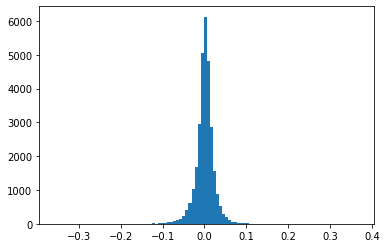

In [120]:
from matplotlib import pyplot as plt
plt.hist(y_it.ravel(),bins=100)
plt.show()

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_it, y_it, test_size=0.33, random_state=42)

def repack(x):
    n,m,k = x.shape
    return x.reshape(n,1,m*k).astype('float32'),m*k

X_train,_ = repack(X_train)
X_test,dim = repack(X_test)
y_train = y_train.astype('float32')

X_it,_ = repack(X_it)
X_oot,_ = repack(X_oot)

In [122]:
tf.random.set_seed(5)


model = keras.Sequential()
#model.add(Dense(100,input_dim=dim))
model.add(BatchNormalization())
model.add(LSTM(30, input_shape=(1, dim)))
model.add(Dense(5))
model.add(BatchNormalization())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_callback = model.fit(X_train, y_train, epochs=150, batch_size=250, verbose=1)
loss_history = history_callback.history["loss"]
np.savetxt("loss_history.txt", loss_history, delimiter=",")

Epoch 1/150
81/81 [==============================] - 3s 9ms/step - loss: 0.1726
Epoch 2/150
81/81 [==============================] - 1s 7ms/step - loss: 0.0157
Epoch 3/150
81/81 [==============================] - 1s 7ms/step - loss: 0.0091
Epoch 4/150
81/81 [==============================] - 1s 7ms/step - loss: 0.0063
Epoch 5/150
81/81 [==============================] - 1s 7ms/step - loss: 0.0049
Epoch 6/150
81/81 [==============================] - 1s 7ms/step - loss: 0.0037
Epoch 7/150
81/81 [==============================] - 1s 7ms/step - loss: 0.0033
Epoch 8/150
81/81 [==============================] - 1s 7ms/step - loss: 0.0027
Epoch 9/150
81/81 [==============================] - 1s 13ms/step - loss: 0.0024
Epoch 10/150
81/81 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 11/150
81/81 [==============================] - 1s 14ms/step - loss: 0.0021
Epoch 12/150
81/81 [==============================] - 1s 14ms/step - loss: 0.0019
Epoch 13/150
81/81 [=============

In [123]:
import tensorflow as tf
tf.keras.models.save_model(
    model, filepath='./saved_keras_models', overwrite=True, include_optimizer=True, save_format=None,
    signatures=None, options=None, save_traces=True
)

INFO:tensorflow:Assets written to: ./saved_keras_models/assets


INFO:tensorflow:Assets written to: ./saved_keras_models/assets


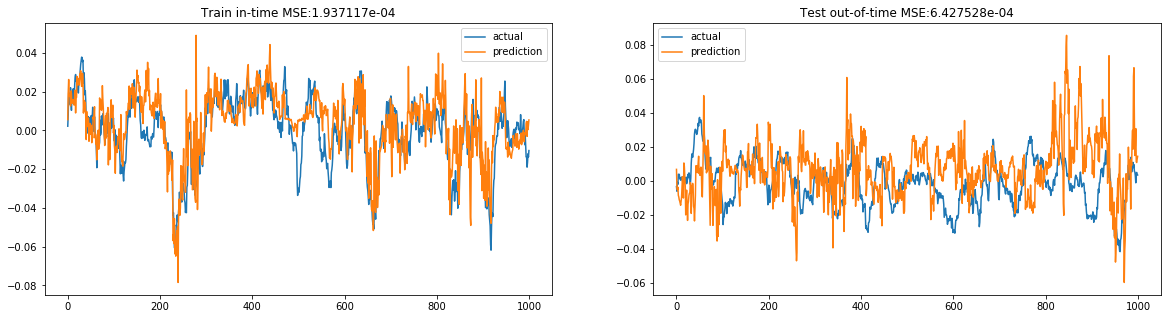

In [124]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

fig,axes = plt.subplots(1,2,figsize=[20,5])

axes[0].plot(y_it[:1000],label='actual')
axes[0].plot(model.predict(X_it[:1000]).ravel(),label='prediction')
mse_train = mean_squared_error(y_it,model.predict(X_it))
axes[0].set_title(f'Train in-time MSE:{mse_train:-4e}')
axes[0].legend()

axes[1].plot(y_oot[:1000],label='actual')
axes[1].plot(model.predict(X_oot[:1000]).ravel(),label='prediction')
mse_test = mean_squared_error(y_oot,model.predict(X_oot))
axes[1].set_title(f'Test out-of-time MSE:{mse_test:-4e}')
axes[1].legend()

plt.show()